### Итоговое задание Александра Соколова
### по Проекту 8. Возьмёте Бэтмобиль? 
####    Юнит 9. NLP/Computer Vision  (отредактирован 17.02.2021)
####    Это приложение к основному ноутбуку содержит разведовательный анализ (EDA)
---

# 1. Импорты библиотек, инициализация глобальных констант, контроль инициализации пакетов и оборудования
## 1.1. Импорты библиотек

In [1]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import math
import sys
import random as rn
# import pandas_profiling
import re


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.19.4


In [2]:
import utils_module06022021_without_GPU as utils

In [3]:
from importlib import reload as reload

## 1.2. Глобальные константы

In [4]:
CURRENT_DIR = './'  # имя текущей директории для локальной машины 
# CURRENT_DIR = '../'  # имя текущей директории для каггл

# проверка пути в папке input для корректного назначения глобальной константы PATH_TO_FILE
print(os.listdir(CURRENT_DIR+'input/'))

['sf-dst-car-price-prediction-part2', 'module8']


In [5]:
PATH_to_FILE = CURRENT_DIR+'input/sf-dst-car-price-prediction-part2/'  # имя директории с исходными файлами
PATH_to_WORKDIR = CURRENT_DIR+'working/'  # имя рабочей директории

RANDOM_SEED = 42  # фиксируем состояние генератора псевдо-случайных чисел для воспроизводимости результата
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(RANDOM_SEED)

!pip3 freeze > requirements.txt  # фиксируем версии всех пакетов для воспроизводимости результата

CURRENT_DATE = dt.now().strftime('[%d.%m.%Y]')  # фиксируем текущую дату для контроля версий экспериментов

# 2. Импорт и предобработка данных
## 2.1. Импорт данных

In [6]:
df_train = pd.read_csv(PATH_to_FILE + 'train.csv')
df_test = pd.read_csv(PATH_to_FILE + 'test.csv')
df_submit = pd.read_csv(PATH_to_FILE + 'sample_submission.csv')

pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))

Размерность тренировочного датасета:  (6682, 22)


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый


In [7]:
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тестового датасета:  (1671, 21)


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый


In [8]:
print('Размерность датасета c примером сабмишена: ', df_submit.shape)
display(df_submit.head(2))

Размерность датасета c примером сабмишена:  (1671, 2)


,sell_id,price
0,1099427284,0
1,1096405886,0


### 2.2. Слияние датасетов в один

In [9]:
# сравним датасеты перед слиянием
utils.check_df_before_merg(df_train, df_test)

,# уник_1,в первой строке_1,тип_1,имя признака_1,имя признака_2,тип_2,в первой строке_2,# уник_2
0,17,седан,object,bodyType,bodyType,object,универсал 5 дв.,14.0
1,3,BMW,object,brand,brand,object,MERCEDES,3.0
2,16,чёрный,object,color,color,object,чёрный,15.0
3,6147,Авто на бодром ходу. Все работает отлично. П...,object,description,description,object,Всем привет!\n\nПродам эксклюзивный проект 124...,1540.0
4,48,3.0 LTR,object,engineDisplacement,engineDisplacement,object,3.0 LTR,43.0
5,146,272 N12,object,enginePower,enginePower,object,220 N12,120.0
6,4,бензин,object,fuelType,fuelType,object,бензин,4.0
7,2900,245000,int64,mileage,mileage,int64,350000,935.0
8,41,2007,int64,modelDate,modelDate,int64,1984,37.0
9,118,5ER,object,model_info,model_info,object,W124,101.0


Резюме:
 1. Не совпали типы в:= 1 столбцах

2. Уникальные значения заоблачно различаются в:= 3 столбцах [3, 7, 14]


,имя признака_1,не совпадают типы,имя признака_2
index,,,
12,price,float64!=nan,NaN


In [10]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

# 3. Предварительный анализ данных

In [11]:
# анализ тренировочной части
# pandas_profiling.ProfileReport(df[df['Train']==1])

In [12]:
# анализ валидационной части
# pandas_profiling.ProfileReport(df[df['Train']==0])

In [13]:
# выведем сводную информацию по датасету df без теста kaggle
utils.describe_without_plots_all_collumns(df[df['Train']==1], short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,bodyType,object,6682,0,17,NaN,NaN,NaN,NaN
1,brand,object,6682,0,3,NaN,NaN,NaN,NaN
2,color,object,6682,0,16,NaN,NaN,NaN,NaN
3,description,object,6682,0,6147,NaN,NaN,NaN,NaN
4,engineDisplacement,object,6682,0,48,NaN,NaN,NaN,NaN
5,enginePower,object,6682,0,146,NaN,NaN,NaN,NaN
6,fuelType,object,6682,0,4,NaN,NaN,NaN,NaN
7,mileage,int64,6682,0,2900,1,120523,999999,111000
8,modelDate,int64,6682,0,41,1975,2010.14,2019,2011
9,model_info,object,6682,0,118,NaN,NaN,NaN,NaN


In [14]:
# выведем сводную информацию по тесту
utils.describe_without_plots_all_collumns(df[df['Train']==0], short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,bodyType,object,1671,0,14,NaN,NaN,NaN,NaN
1,brand,object,1671,0,3,NaN,NaN,NaN,NaN
2,color,object,1671,0,15,NaN,NaN,NaN,NaN
3,description,object,1671,0,1540,NaN,NaN,NaN,NaN
4,engineDisplacement,object,1671,0,43,NaN,NaN,NaN,NaN
5,enginePower,object,1671,0,120,NaN,NaN,NaN,NaN
6,fuelType,object,1671,0,4,NaN,NaN,NaN,NaN
7,mileage,int64,1671,0,935,1,119725,1e+06,109000
8,modelDate,int64,1671,0,37,1971,2009.98,2019,2011
9,model_info,object,1671,0,101,NaN,NaN,NaN,NaN


Резюме по предварительному анализу: (выводы идут по порядку выявления, а не по значимости)  
В тренировочной выборке 6682 строк, в тестовой 1671. Всего - 8353 строк. Всего 23 признака, из них: 
  - 5 - числовых - mileage, modelDate, productionDate, numberOfDoors, sell_id (sell_id- сервисный признак)  
  - 17 - категориальных - пока так, во время анализа, вероятно, какие-нибудь из них станут числовыми  
  - 1 - бинарный - Train  - сервисный для разделения train и test
  
Детальная информация по трейну и тесту:  
- характерно для теста и трейна:
  - руль - очень уникальный признак почти все значения "левый руль", только 2 строки из 6682 - выбросы "правый руль"  => надо еще внимательно посмотреть на этапе анализа - удалить выбросы, а потом удалить признак
  - высокая корреляция между modelDate и productionDate => надо еще внимательно посмотреть на этапе анализа
  - высокая корреляция между  numberOfDoors и bodyType => надо еще внимательно посмотреть на этапе анализа
  - между vehicleConfiguration и еще 2-мя признаками: vehicleTransmission, engineDisplacement - высокая корреляция => надо проверить это при анализе и при необходимости удалить  
  - sell_id хоть и сервисный признак, но в нем наблюдается сильный перекос в данных (вероятно из-за того что датасет формировался в разное время или разными способоми, надо обратить на это внимание во время EDA)   

- по трейну:
  - в трейне нет дубликатов по строкам
  - пропуски в трейне:
    - Владение - 4326 (64.7%) => очень много пропусков надо попробовать заполнить, если не получится, тогда удалить
    - Владельцы - 1(< 0.1%) => один пропуск, надо попробовать заполнить

- по тесту:    
  - пропуски в тесте:
    - Владение - 1092 (65.4%) => очень много пропусков надо попробовать заполнить, если не получится, тогда удалить
    - price - 1671 (100.0%) 

Описания полей датасета:
- bodyType - тип кузова автомобиля (https://ru.wikipedia.org/wiki/Типы_автомобильных_кузовов)
- brand - марка (бренд) автомобиля
- color	- цвет автомобиля (16 цветов: чёрный, красный, синий, серебристый, зелёный, белый, серый, голубой, пурпурный, коричневый, золотистый, фиолетовый, жёлтый, оранжевый, розовый)
- description - дополнительные характеристики по комплектации авто
- engineDisplacement - объем двигателя в литрах
- enginePower - мощность двигателя (л.с.)
- fuelType - тип топлива (5 видов топлива: бензин, дизель, электро, гибрид, газ)
- mileage - пробег автомобиля (км.) - представляет собой общее количество километров, которое это транспортное средство проехало по дорогам с момента своего схода с конвейера производителя. 
- modelDate - дата (год) выпуска модели (!!!внимание!!! не путать с датой производства)
- model_info - 
- name - комбинация нескольких характеристик (модели, объема двигателя и привода)
- numberOfDoors - кол-во дверей
- price - цена указанная в объявлении на авто.ру
- productionDate - дата (год) производства авто
- sell_id - сервисный признак для генерации submition, а также для обращения к фото авто
- vehicleConfiguration - комбинация типа трансмиссии, объема двигателя и мощности двигателя
- vehicleTransmission - тип трансмиссии (коробки передач) (4 вида: автоматическая, механическая, роботизированная, вариатор)
- Владельцы - кол-во владельцев (3 значения: 1 владелец, 2 владельца, 3 и более)
- Владение - срок владения автомобилем в годах и месяцах
- ПТС - тип ПТС (паспорт технического средства)(2 значения - оригинал, дубликат)
- Привод - характеристика привода автомобиля, которое передает энергию от двигателя на колеса. Переднеприводные автомобили получают всю энергию двигателя на передние колеса. При заднем приводе энергия двигателя целиком поступает на задние колеса. Когда энергия двигателя передается на все четыре колеса автомобиля, такой привод является полным ('полный', 'передний', 'задний')
- Руль - характеристика руля по стороне расположения руля в автомобиле (Левый, Правый)
- Train - сервисный признак для разделения train и test

In [15]:
# внесем данные по типам переменных из резюме в списки 

# бинарная переменная (0) Train внесем в список сервисных
bin_cols = []
# категориальные переменные (17), (Руль пока уставляем так как надо избавится от выбросов)
cat_cols = ['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'model_info', 'name',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль']
# числовые переменные (4) sell_id внесем в список сервисных
num_cols = ['mileage', 'modelDate', 'productionDate', 'numberOfDoors']
# сервисные переменные (2)
servis_cols = ['Train', 'sell_id']
# целевая переменная (1)
target_col = ['price']
# итого 0+16+4+2+1=28

all_cols =cat_cols + num_cols + servis_cols + bin_cols + target_col
print(f'Кол-во столбцов, для дальнейшей работы после предварительного анализа:= {len(all_cols)}')

Кол-во столбцов, для дальнейшей работы после предварительного анализа:= 23


In [16]:
old_len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне до EDA:= ', old_len_train)

Кол-во строк в трейне до EDA:=  6682


# 4. Детальный разведовательный анализ по переменным (EDA)
---
## 4.1 bodyType

In [17]:
# так как признаков много создаем список проанализированных признаков, чтобы можно было посмотреть, что осталось сделать  
EDA_done_cols=[]

In [18]:
df = utils.auto_eda_cat_col('bodyType',
                            'тип кузова',
                            df)

EDA по категориальному признаку:= bodyType (тип кузова)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 17
===
КУЗ в трейне:= 17
КУЗ в тесте:= 14
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'внедорожник 5 дв.', 'хэтчбек 3 дв.', 'родстер', 'внедорожник открытый', 'внедорожник 3 дв.', 'хэтчбек 5 дв.', 'кабриолет', 'купе', 'лифтбек', 'универсал 5 дв.', 'пикап двойная кабина', 'седан 2 дв.', 'лимузин', 'компактвэн', 'седан', 'минивэн', 'купе-хардтоп'}
СУЗ в тесте:=  {'внедорожник 5 дв.', 'хэтчбек 3 дв.', 'родстер', 'внедорожник открытый', 'внедорожник 3 дв.', 'хэтчбек 5 дв.', 'кабриолет', 'купе', 'универсал 5 дв.', 'лифтбек', 'пикап двойная кабина', 'седан', 'минивэн', 'купе-хардтоп'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= {'лимузин', 'седан 2 дв.', 'компактвэн'}
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===

Кол-во строк критерия тип кузова=='лимузин' в трейне := 5     (0.07% от трейна). Рекомендую уд

***Резюме по bodyType:-*** Категориальный признак. Удалили 3 типа кузова как выбросы. Оставили 14 типов кузовов как в тесте, так как типы кузовов отличающиеся от кузовов в тесте очень специфичны и очень сильно влияют на класс автомобиля по которому по общим закономерностям формируется цена, оставим только типы кузова из теста, а потом после EDA проверим достаточно ли большая выборка трейна остается для моделирования или необходимо парсить другие сайты. Пропусков нет.

In [19]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('bodyType', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= bodyType, обработано признаков:= 1, осталось:= 22
Кол-во строк в трейне:=  6668 . Убрали на данном шаге:=  14
Кол-во строк в тесте:=  1671


## 4.2 brand

In [20]:
df = utils.auto_eda_cat_col('brand',
                            'марка автомобиля',
                            df)

EDA по категориальному признаку:= brand (марка автомобиля)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 3
===
КУЗ в трейне:= 3
КУЗ в тесте:= 3
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'AUDI', 'BMW', 'MERCEDES'}
СУЗ в тесте:=  {'MERCEDES', 'BMW', 'AUDI'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= set()
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===
Различий в списках уникальных значений нет.


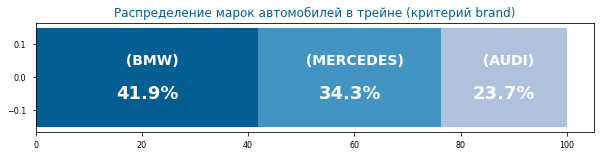

In [21]:
utils.simple_plot_barh_procent('Распределение марок автомобилей в трейне', ['','',''], 'brand',df[df['Train']==1])

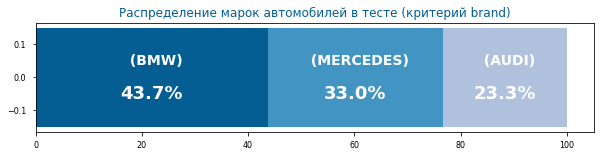

In [22]:
utils.simple_plot_barh_procent('Распределение марок автомобилей в тесте', ['','',''], 'brand',df[df['Train']==0])

***Резюме по brand*** - Категориальный признак. Три уникальных значения - AUDI, MERCEDES, BMW. Распределение марок в трейне и в тесте отлично сбалансировано. Распределение марок внутри отличается - BMW(41-43%%), MERCEDES(34-33%%), AUDI(23%). Так AUDI почти в два раза меньше чем BMW. Из этого следует что во время перекрестного анализа признаков, необходимо обратить внимание на распределения по маркам, а также попробовать сформировать валидационную выборки в соответствии с пропорциями марок. Рассмотреть вариант обучения моделей по маркам отдельно. Пропусков нет. 

In [23]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('brand', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= brand, обработано признаков:= 2, осталось:= 21
Кол-во строк в трейне:=  6668 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.3 color

In [24]:
df = utils.auto_eda_cat_col('color',
                            'цвет',
                            df)

EDA по категориальному признаку:= color (цвет)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 16
===
КУЗ в трейне:= 16
КУЗ в тесте:= 15
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'белый', 'серебристый', 'чёрный', 'серый', 'голубой', 'фиолетовый', 'зелёный', 'бежевый', 'коричневый', 'синий', 'красный', 'жёлтый', 'розовый', 'пурпурный', 'оранжевый', 'золотистый'}
СУЗ в тесте:=  {'белый', 'серый', 'чёрный', 'серебристый', 'голубой', 'фиолетовый', 'зелёный', 'бежевый', 'коричневый', 'синий', 'красный', 'жёлтый', 'пурпурный', 'оранжевый', 'золотистый'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= {'розовый'}
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===

Кол-во строк критерия цвет=='розовый' в трейне := 1     (0.01% от трейна). Рекомендую удалить.

***Резюме по color:-*** Категориальный признак. Удалил 1 цвет == розовый как выброс. Оставили 15 цветов как в тесте. Пропусков нет.

In [25]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('color', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= color, обработано признаков:= 3, осталось:= 20
Кол-во строк в трейне:=  6667 . Убрали на данном шаге:=  1
Кол-во строк в тесте:=  1671


## 4.4 engineDisplacement

In [26]:
df = utils.auto_eda_cat_col('engineDisplacement',
                            'объём двигателя',
                            df)

EDA по категориальному признаку:= engineDisplacement (объём двигателя)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 48
===
КУЗ в трейне:= 48
КУЗ в тесте:= 43
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'3.8 LTR', '3.0 LTR', '2.8 LTR', '3.1 LTR', '3.7 LTR', '5.8 LTR', '2.7 LTR', '5.5 LTR', '1.2 LTR', '4.7 LTR', '2.4 LTR', '1.3 LTR', '1.8 LTR', '3.5 LTR', '2.9 LTR', '2.0 LTR', '5.6 LTR', '2.5 LTR', '4.1 LTR', '1.5 LTR', '5.2 LTR', '4.8 LTR', '5.9 LTR', 'undefined LTR', '4.6 LTR', '2.3 LTR', '3.2 LTR', '4.9 LTR', '4.3 LTR', '5.0 LTR', '5.4 LTR', '6.2 LTR', '6.6 LTR', '1.4 LTR', '4.4 LTR', '2.6 LTR', '4.2 LTR', '3.4 LTR', '6.0 LTR', '4.0 LTR', '2.1 LTR', '0.7 LTR', '6.3 LTR', '2.2 LTR', '1.9 LTR', '1.7 LTR', '3.6 LTR', '1.6 LTR'}
СУЗ в тесте:=  {'3.8 LTR', '3.0 LTR', '3.1 LTR', '3.7 LTR', '5.8 LTR', '2.7 LTR', '5.5 LTR', '1.2 LTR', '4.7 LTR', '2.4 LTR', '1.3 LTR', '1.8 LTR', '3.5 LTR', '2.9 LTR', '2.0 LTR', '2.5 LTR', '4.1 LTR', '1.5 LTR', '1.6 LTR', '5.2 LTR', 

In [27]:
# можно заметить что в списке присутствует не типичное значение 'undefined LTR'
# давайте посмотрим что это за авто (вероятнее всего это электрокары)
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]

temp_df_Train[temp_df_Train['engineDisplacement']=='undefined LTR'].fuelType.unique()

array(['электро'], dtype=object)

In [28]:
# да так и есть, кто-то за нас уже убрал информацию о мощности двигателей электрокаров и подготовил для нас датасет 
# по опыту работы над проектом 6 надо проверить, что в электрокары случайно не попали гибриды с двигателями 0.6-0.8 м3 
# убедимся в этом
temp_df_Train[temp_df_Train['fuelType']=='электро'].engineDisplacement.unique()

array(['undefined LTR'], dtype=object)

In [29]:
# также проверим тест
temp_df_Test[temp_df_Test['fuelType']=='электро'].engineDisplacement.unique()

array(['undefined LTR'], dtype=object)

In [30]:
# прекрасно теперь перейдем к парсингу числовой информации из признака engineDisplacement
# обработаем значения с помощью регулярных выражений найдя значения объема в литра типа 2.0 и переведем их см3 
def pars_num_from_engineDisplacement(row):
    row = str(row)
    temp_pars = re.findall('\d\.\d', row)
    
    if temp_pars == []:
        return None  # мы заполняем None, но очень важно, чтобы у модели была возможность использовать признак электрокара
                  # если тут будет стоят ноль, то какой бы гипотетический коэффициент мы к нему не применяли он все равно
                  # их композиция останется нулем и не будет делать вклад в ценообразование. 
                  # Для этого мы на этапе анализа вида топлива создадим отдельную колонку по электрокарам с единицами и 
                  # таким образом автоматически решим эту проблему. Но важно помнить, что при нормализации и стандартизации
                  # ноль может смещаться и начинать вносить ненужный нам вклад. Поэтому мы ставим None и после нормализации 
                  # и стандартизации мы заполним пропуски средними значениями в зависимости от применяемой нами функции  
    else:
        result_volume_of_engine = int(float(temp_pars[0])*1000)

    return result_volume_of_engine
df['engineDisplacement2'] = df['engineDisplacement'].apply(pars_num_from_engineDisplacement)

In [31]:
# добавим мощность двигателя engineDisplacement2 в числовые признаки, а engineDisplacement удалим
cat_cols.remove('engineDisplacement') 
num_cols.append('engineDisplacement2')

In [32]:
# теперь когда признак объем двигателя перешел в разряд числового приступим к его анализу как числового признака
utils.describe_without_plots('engineDisplacement2', df[df['Train']==1].engineDisplacement2)

,engineDisplacement2
кол-во строк,6650
тип значений,float64
кол-во значений,6645
кол-во NaN,5
среднее,2778.34
медиана,2800
мин,700
макс,6600


In [33]:
# минимальные значения соответствуют гибридам, убедимся в этом 
df[df['engineDisplacement2']==700][['brand','fuelType', 'engineDisplacement', 'engineDisplacement2']].head(10)

,brand,fuelType,engineDisplacement,engineDisplacement2
127,BMW,гибрид,0.7 LTR,700.0
857,BMW,гибрид,0.7 LTR,700.0
2905,BMW,гибрид,0.7 LTR,700.0
3082,BMW,гибрид,0.7 LTR,700.0
3651,BMW,гибрид,0.7 LTR,700.0
7827,BMW,гибрид,0.7 LTR,700.0


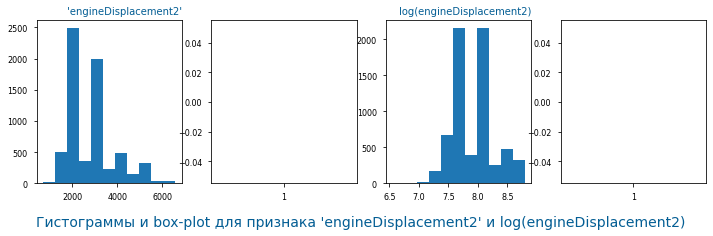

In [35]:
utils.four_plot_with_log2('engineDisplacement2', df[df['Train']==1 & ~df['engineDisplacement2'].isna()])

In [41]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('engineDisplacement2',df[df['Train']==1], log = False)

,левая,правая
границы выбросов,500.0,4500.0
кол-во значений за границей,0.0,547.0


In [41]:
import matplotlib.pyplot as plt

def four_plot_with_log2(d_name_column,d_df):
    
    plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = (12, 3)
    color_text = plt.get_cmap('PuBu')(0.85)

    
    temp_df=d_df.copy()

    fig = plt.figure()

   
    ax_1 = fig.add_subplot(1, 4, 1)
    ax_2 = fig.add_subplot(1, 4, 2)
    ax_3 = fig.add_subplot(1, 4, 3)
    ax_4 = fig.add_subplot(1, 4, 4)

    plt.suptitle(f'Гистограммы и box-plot для признака \'{d_name_column}\' и log({d_name_column})', fontsize=14, color = color_text, y=-0.02)

    ax_1.hist(temp_df[d_name_column],bins=11)
    ax_1.set_title(f'\'{d_name_column}\'', loc = 'right', fontsize=10, color = color_text)
    ax_2.boxplot(temp_df[d_name_column])
    
    temp_name = 'log_'+d_name_column
    temp_df.loc[:,temp_name] =  temp_df[d_name_column].apply(lambda x: math.log(x+1))

    ax_3.hist(temp_df[temp_name],bins=11)
    ax_3.set_title(f'log({d_name_column})', loc = 'right', fontsize=10, color = color_text)
    ax_4.boxplot(temp_df[temp_name])
    
    plt.show()
    return

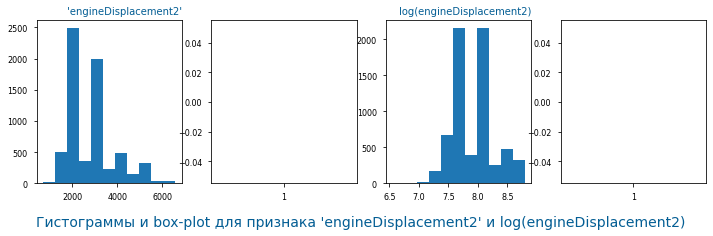

In [42]:
four_plot_with_log2('engineDisplacement2', df[df['Train']==1 & ~df['engineDisplacement2'].isna()])

In [40]:

temp_df=df.copy()

fig = plt.figure()

data = temp_df

ax_1 = fig.add_subplot(1, 1, 1)

ax_1.boxplot(x='engineDisplacement2', data=data)

plt.show()

NameError: name 'plt' is not defined

In [45]:
data.shape

(8321, 24)

In [39]:
import matplotlib 
print(matplotlib.__version__)

3.2.1


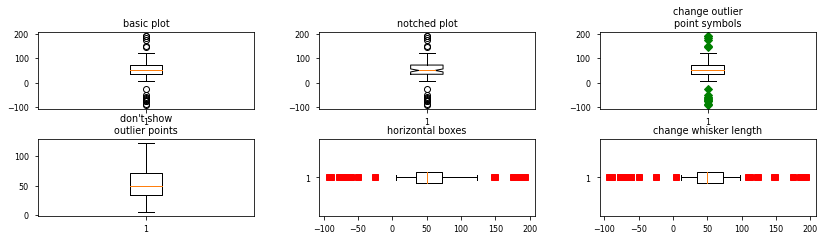

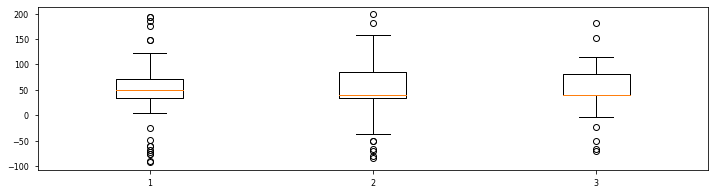

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon


# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

fig, axs = plt.subplots(2, 3)

# basic plot
axs[0, 0].boxplot(data)
axs[0, 0].set_title('basic plot')

# notched plot
axs[0, 1].boxplot(data, 1)
axs[0, 1].set_title('notched plot')

# change outlier point symbols
axs[0, 2].boxplot(data, 0, 'gD')
axs[0, 2].set_title('change outlier\npoint symbols')

# don't show outlier points
axs[1, 0].boxplot(data, 0, '')
axs[1, 0].set_title("don't show\noutlier points")

# horizontal boxes
axs[1, 1].boxplot(data, 0, 'rs', 0)
axs[1, 1].set_title('horizontal boxes')

# change whisker length
axs[1, 2].boxplot(data, 0, 'rs', 0, 0.75)
axs[1, 2].set_title('change whisker length')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

# fake up some more data
spread = np.random.rand(50) * 100
center = np.ones(25) * 40
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
d2 = np.concatenate((spread, center, flier_high, flier_low))
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
data = [data, d2, d2[::2]]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)

plt.show()

In [27]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('engineDisplacement', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= engineDisplacement, обработано признаков:= 4, осталось:= 19
Кол-во строк в трейне:=  6650 . Убрали на данном шаге:=  17
Кол-во строк в тесте:=  1671


<module 'utils_module06022021_without_GPU' from '/home/aleks/GitHub/skillfactory_rds/module_8/utils_module06022021_without_GPU.py'>

In [ ]:
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]

In [ ]:

reload(utils)